In [1]:
## How to do a volume weighted mean!!! Courtesy of Graeme MacGilchrist :)! 
## This method is important since our model doesn't have evenly sized "boxes" (cells?) 
## We'll be using volume weighted mean to have a fixed volume for our analyses
    # Many of the variables that we're working with has units in mol m^-3 
    # When we multiply by volume (units = m^3), we're only left with moles
    # We need to then sum the total of all of the products in a specific "box" or cell of the model 
    # We also need to divide by the sum of the volume so that our final units will again be in mol m^-3 
    # This will give us an adjusted/fixed volume for us to accurately compare our data

In [2]:
import xarray as xr
import numpy as np 
from matplotlib import pyplot as plt

In [3]:
## For this example we'll be using phytoplankton and temperature binned together 
## The main thing to remember is to NOT bin phytoplankton and temperature together BEFORE calculating the volume weighted mean
## Trust me; I've tried this and it only caused errors, headaches, and tears in my non-air conditioned apartment


In [4]:
rootdir = '/archive/oar.gfdl.cmip6/ESM4/DECK/ESM4_piControl_D/gfdl.ncrc4-intel16-prod-openmp/pp/'
datadir_temperature = 'ocean_monthly_z/ts/monthly/5yr/'
filename_temperature = 'ocean_monthly_z.071101-071512.thetao.nc'



datadir_phytoplankton = 'ocean_cobalt_omip_tracers_month_z/ts/monthly/5yr/'
filename_phytoplankton = 'ocean_cobalt_omip_tracers_month_z.071101-071512.phyc.nc'


temperature = xr.open_dataset(rootdir+datadir_temperature+filename_temperature)
phytoplankton = xr.open_dataset(rootdir+datadir_phytoplankton+filename_phytoplankton)

/nbhome/Alexandra.Matthews/miniconda/envs/basic/lib/python3.7/site-packages/xarray/coding/times.py:419: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  self.use_cftime)


In [5]:
## Even though I said to NOT bin temperature and phytoplankton together, we still need to merge the temperature and phytoplankton arrays..
## ..together so that we can have the combined units into one dataset 

ds = xr.merge([temperature, phytoplankton])

## We can check to see the variables that are now in this dataset 

print(ds)


<xarray.Dataset>
Dimensions:     (nv: 2, time: 60, xh: 720, yh: 576, z_i: 36, z_l: 35)
Coordinates:
  * nv          (nv) float64 1.0 2.0
  * time        (time) object 0711-01-16 12:00:00 ... 0715-12-16 12:00:00
  * xh          (xh) float64 -299.8 -299.2 -298.8 -298.2 ... 58.75 59.25 59.75
  * yh          (yh) float64 -77.91 -77.72 -77.54 -77.36 ... 89.47 89.68 89.89
  * z_i         (z_i) float64 0.0 5.0 15.0 25.0 ... 5.75e+03 6.25e+03 6.75e+03
  * z_l         (z_l) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
Data variables:
    average_DT  (time) timedelta64[ns] 31 days 28 days ... 30 days 31 days
    average_T1  (time) object 0710-07-08 00:00:00 ... 0715-06-06 00:00:00
    average_T2  (time) object 0710-08-08 00:00:00 ... 0715-07-07 00:00:00
    thetao      (time, z_l, yh, xh) float32 ...
    time_bnds   (time, nv) object 0711-01-01 00:00:00 ... 0716-01-01 00:00:00
    phyc        (time, z_l, yh, xh) float32 ...


/nbhome/Alexandra.Matthews/miniconda/envs/basic/lib/python3.7/site-packages/numpy/core/numeric.py:538: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/nbhome/Alexandra.Matthews/miniconda/envs/basic/lib/python3.7/site-packages/numpy/core/numeric.py:538: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


In [7]:
## You can see that temperature "thetao" and phytoplankton "phyc" are now in the dataset titles "ds"

## Now let's create the name for the volume variable 
    # Just to clear any confusion, phytoplankton and volume are in the same data directory so I just used the data directory that..
    #..I had named "datadir_phytoplankton"
    
filename_volume = 'ocean_cobalt_omip_tracers_month_z.071101-071512.volcello.nc'
volume = xr.open_dataset(rootdir+datadir_phytoplankton+filename_volume)

In [8]:
## Cool, now here's the part that made me cry :'( 
## We're going to merge the contents that are in the variable "ds" (remember: this contains the merged phytoplankton and temperature data)
## Again, this will combine all of our variables and units into one dataset

df = xr.merge([ds, volume])

## We now have phytoplankton, temperature, and volume in one dataset

/nbhome/Alexandra.Matthews/miniconda/envs/basic/lib/python3.7/site-packages/numpy/core/numeric.py:538: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/nbhome/Alexandra.Matthews/miniconda/envs/basic/lib/python3.7/site-packages/numpy/core/numeric.py:538: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


In [9]:
## The formula for a volume weighted mean is sum((variable with m^-3)(volume)) / sum(volume)
# Let's make a variable for the un-summed part of the numerator (the phytoplankton and volume part of the variable "df")

pV = df.volcello*df.phyc
pV.name = 'pV'
df = xr.merge([df,pV])

## By merging the variable "pV" with "df", we combine these data arrays to make one distinct variable (un-summed part of the numerator)..
## ..in the dataset "df" 


In [10]:
## NOW WE DO SOME BINNING! 
# We're going to bin "df" (the dataset with pV and the rest of the variables in df) with temperature
# We will also bin volume with temperature for when we divide the numerator by the denominator in the volume weighted mean formula
# Additionally, we need to bin "pV" since that's our numerator in the volume weighted mean formula 

df = df.set_coords('thetao')
theta_bins = np.arange(-2,30,2) # This specifies the range of the bins! It's totally up to how you want to arrange your graph. 
pV_in_theta = df.pV.isel(time=5,z_l=0).groupby_bins('thetao',theta_bins)
V_in_theta = df.volcello.isel(time=5,z_l=0).groupby_bins('thetao',theta_bins)

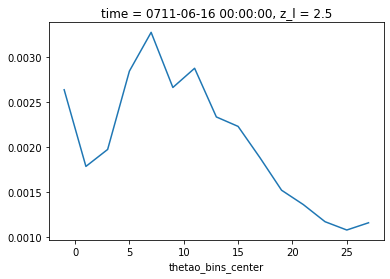

In [11]:
## And finally the moment that we've (well, I've) been waiting for:

p_vmean = pV_in_theta.sum(xr.ALL_DIMS)/V_in_theta.sum(xr.ALL_DIMS)

p_vmean.plot()

In [12]:
## And there you have it! It was really so simple to be honest. Well, simple after Graeme explained it :)! 
## You can apply this script to any variables where you're looking to compare different cells of the model. 
## Alrighty, happy coding! Thanks again Graeme; you're the best! My headache and tears were worth it (not really though). 